### MCP Image Anaylsis Step-by-Step ###

Reading MCP image: /Users/denizyoldas/Desktop/n2dec_analysis_v1/mcp_results/originals/0840_38.764.tif
Analyzing image...
Image dimensions: 512 x 640
Net Intensity (NNI): 2.85e+05


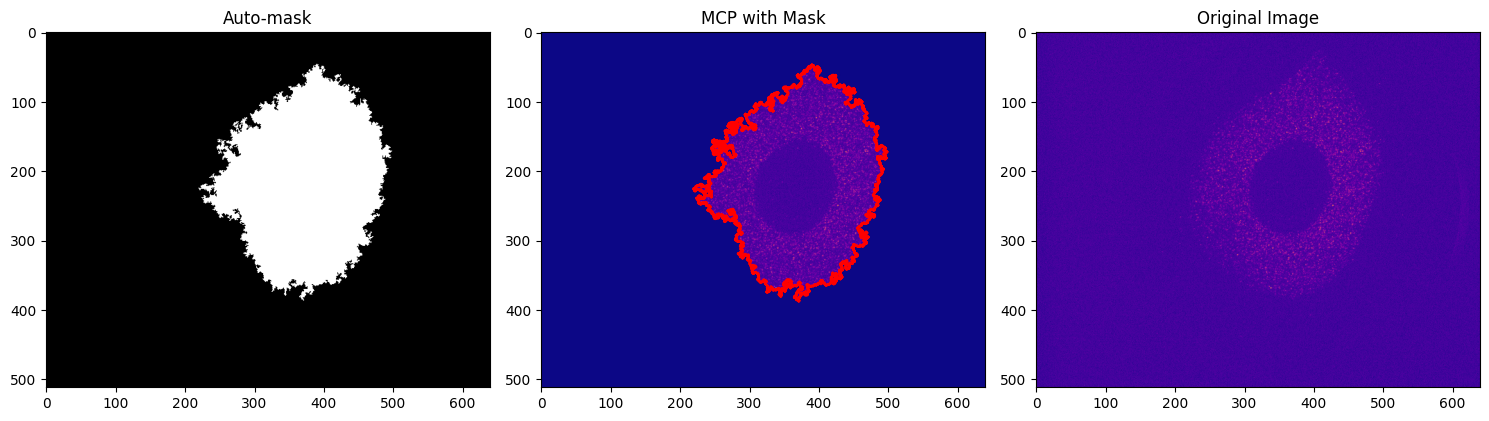

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.ndimage import binary_fill_holes

cwd = os.getcwd()
mcp_tif = os.path.join(cwd, "mcp_results", "originals", "0840_38.764.tif")
# run_number = input("Run number: ")

print(f"Reading MCP image: {mcp_tif}")

# Read mcp file, convert it to a 2d numpy array with values as float64 (originally uint16)
mcp_image = plt.imread(mcp_tif).astype(np.float64)

# Subtract minimum (offset) from whole image
# MCP offset is usually high, signal covers a small portion on top of the offset
mcp_image -= np.amin(mcp_image)

# Optional
# Crop
# mcp_image = mcp_image[380:600, 500:700]
    
# Optional
# Remove bright positron image before continuing Be+ plasma extraction
# Needs trial and error
# Upground estimate and set to 0
# ug_estimate = np.percentile(mcp_image, 83)
# mcp_image[mcp_image > ug_estimate] = 0

# Stats
n, m = mcp_image.shape
print("Analyzing image...")
print(f"Image dimensions: {n} x {m}")

# === AUTOMATIC MASK CREATION ===

# 1. Estimate background using low percentile (avoid using mean, as plasma can bias it)
# Lower 10th percentile is good background estimation, also calculate standard deviation of the background
bg_estimate = np.percentile(mcp_image, 10)
std_estimate = np.std(mcp_image[mcp_image < bg_estimate + 1e-7])

# 2. Threshold: anything much brighter than background is considered plasma
# Background plus 4sigma is common threshold estimate at plasma imaging
threshold = bg_estimate + 4 * std_estimate
initial_mask = (mcp_image > threshold).astype(np.uint8)

# 3. Connected components: label blobs
labeled, num_features = label(initial_mask)
if num_features == 0:
    print("No plasma region detected. Exiting.")
    exit()

# 4. Select the largest blob as the plasma, label numbers start at 1
sizes = [np.sum(labeled == i) for i in range(1, num_features+1)]
biggest = np.argmax(sizes) + 1
mask_image = (labeled == biggest).astype(np.uint8)

# 5. Fill holes inside the mask (for hollow plasma regions)
mask_image = binary_fill_holes(mask_image).astype(np.uint8)

# MCP image with background substracted
mcp_image_clean = mcp_image - threshold

# Invert mask
antimask = 1 - mask_image

# Masked and antimasked mcp image
masked_mcp = mask_image * mcp_image
antimasked_mcp = antimask * mcp_image

# Non-mask (background) region, and total, and net (plasma) intensity
total_intensity = np.sum(mcp_image)
background = np.mean(mcp_image[antimask != 0])
background_int = background * n * m
intensity = total_intensity - background_int

print(f"Net Intensity (NNI): {intensity:.2e}")

# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Auto-mask')
plt.imshow(mask_image, cmap='gray')
plt.subplot(1,3,2)
plt.title('MCP with Mask')
plt.imshow(masked_mcp, cmap='plasma')
plt.contour(mask_image, colors='r')
plt.subplot(1,3,3)
plt.title('Original Image')
plt.imshow(mcp_image, cmap='plasma')
plt.tight_layout()
plt.show()



Plasma center estimated at (x=373.23, y=217.47)
Automated chordlength = 201


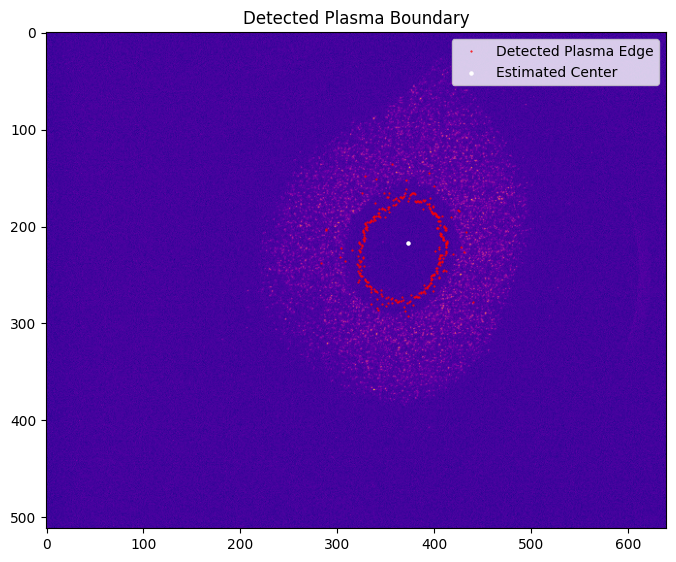

In [2]:
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

# Estimate plasma center using mask center of mass
y_c_rough, x_c_rough = center_of_mass(masked_mcp)
print(f"Plasma center estimated at (x={x_c_rough:.2f}, y={y_c_rough:.2f})")

# === AUTOMATE CHORDLENGTH ===

# 1. Mask coordinates and center coordinate in tuples of (x, y)
mask_coords = np.column_stack(np.nonzero(mask_image))
center_coord = np.array([[y_c_rough, x_c_rough]])

# 2. Euclidean distance between center_coord and every plasma pixel coordinate in mask_coords.
dists = cdist(center_coord, mask_coords)

# 3. Maximum euclidian distance from the center and little bit buffer into background
chordlength = int(np.max(dists)) + 30
print(f"Automated chordlength = {chordlength}")

# Chord integration from center
N_chords = 300
phi = np.linspace(0, 2*np.pi, N_chords)

chord = []
for angle in phi:
    values = []
    for step in range(chordlength):
        x = int(round(x_c_rough + np.cos(angle) * step))
        y = int(round(y_c_rough + np.sin(angle) * step))
        if 1 < x < (m-2) and 1 < y < (n-2):
            region = mcp_image_clean[y-1:y+2, x-1:x+2]
            values.append(region.mean())
        else:
            values.append(0)
    chord.append(values)

chord = np.array(chord)

# Smooth each chord using running mean
def running_mean(x, N):
    return np.convolve(x, np.ones(N)/N, mode='valid')

Nrun1 = 16
chord_rm = np.array([running_mean(c, Nrun1) for c in chord])

# Compute gradient and smooth again
chord_grad = np.diff(chord_rm, axis=1)
Nrun2 = 16
chord_grad_rm = np.array([running_mean(g, Nrun2) for g in chord_grad])

# Find the max gradient halft the way along each chord (plasma edge)
cmax_radius = chord_grad_rm[:, :chordlength//2].argmax(axis=1)

# Calculate (x, y) coordinates of edge points (the detected ellipse)
ex_coord = x_c_rough + cmax_radius * np.cos(phi)
ey_coord = y_c_rough + cmax_radius * np.sin(phi)

# Plot the edge points over the MCP image
plt.figure(figsize=(8, 8))
plt.imshow(mcp_image_clean, cmap='plasma', origin='upper')
plt.plot(ex_coord, ey_coord, 'r.', markersize=1, label='Detected Plasma Edge')
plt.scatter([x_c_rough], [y_c_rough], color='white', s=5, label='Estimated Center')
plt.title("Detected Plasma Boundary")
plt.legend()
plt.show()



In [3]:
# This includes the mm/pixels calibration
# The fringe factor in B=1T
# Therefore converts pixels -> size in trap @B=1T
# b_calibration_factor = 0.086/8.74 (From Jack's analyses)
# b_calibration_factor = 0.086/9.74 (Best for 2019 data)
# b_calibration_factor = 2.5 * 0.086/9.74 (Best for 2025 data)
b_calibration_factor = 0.086/9.74

Ellipse center = (x=365.59, y=222.10)
Angle of rotation = 1.7203 rad
Axes = a: 53.74, b: 47.78


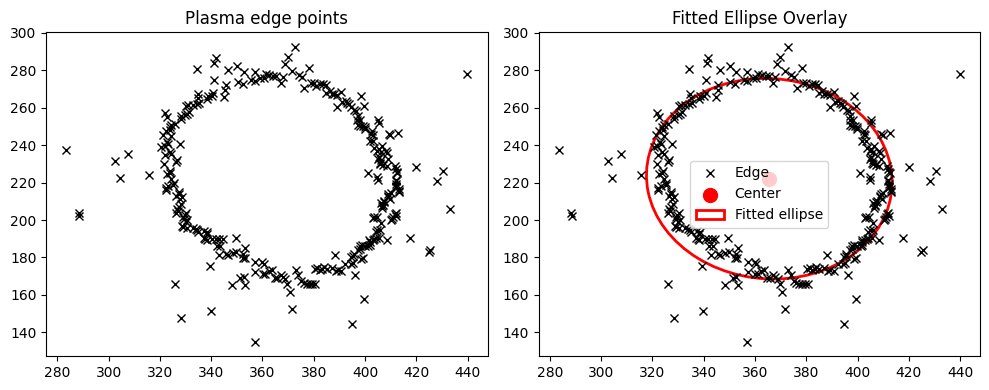

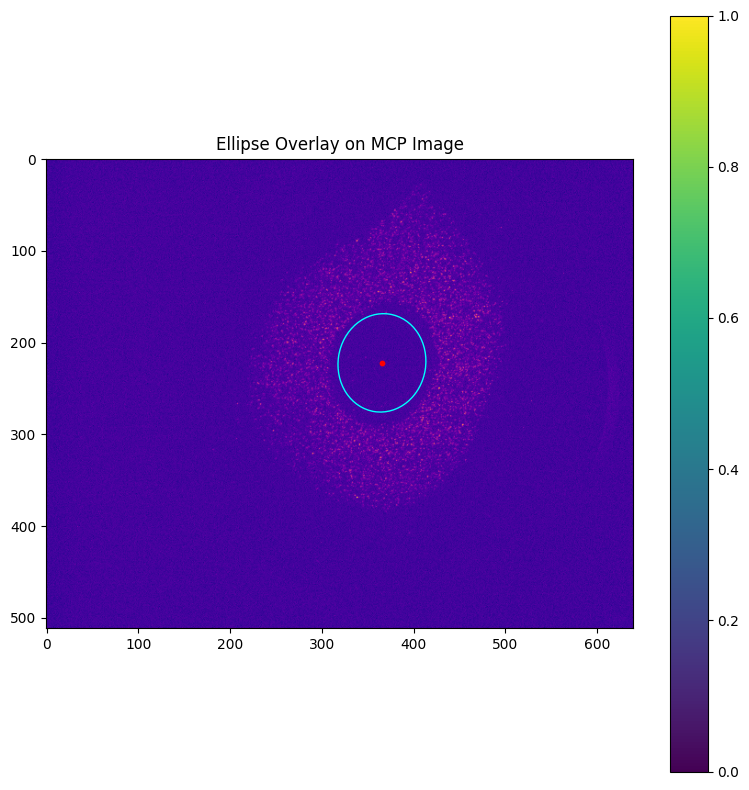

Computing circularized radial density profile...


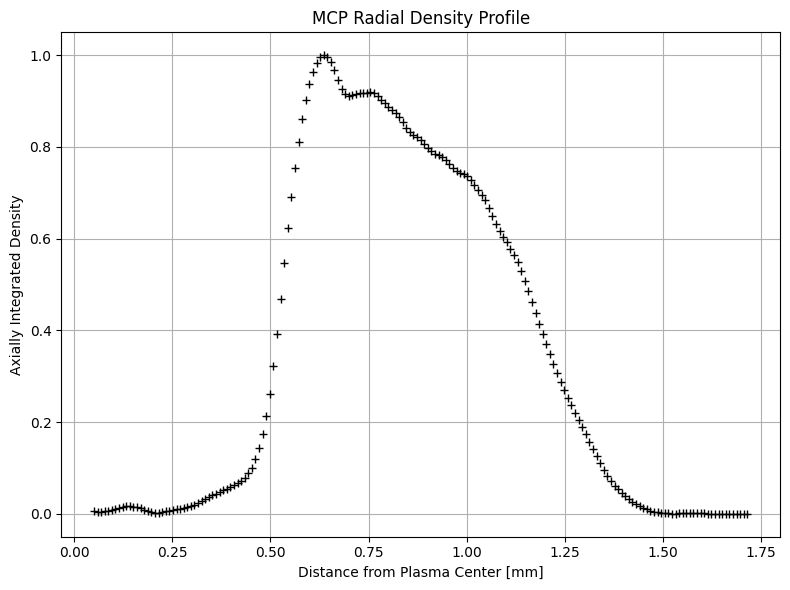

In [4]:
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import stats

# Copy edge points into NDArrays
x = np.array(ex_coord)
y = np.array(ey_coord)

# Stack x & y coordinates into two columns: [[x0,y0], ...]
a_points = np.column_stack((x, y))

# Fit ellipse to plasma edge coordinates
ell = EllipseModel()
ell.estimate(a_points)

# Extract ellipse center coordinates, semi-major/minor axes, & counterclockwise rotation of major axis in radians
xc, yc, a, b, theta = ell.params

print(f"Ellipse center = (x={xc:.2f}, y={yc:.2f})")
print(f"Angle of rotation = {theta:.4f} rad")
print(f"Axes = a: {a:.2f}, b: {b:.2f}")

# Plot detected edge points and fitted ellipse
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(x, y, 'x', color='black')
axs[0].set_title('Plasma edge points')

axs[1].plot(x, y, 'x', color='black', label='Edge')
axs[1].scatter(xc, yc, color='red', s=100, label='Center')
# Ellipse overlay
ell_patch = Ellipse(
    (xc, yc), width=2*a, height=2*b, angle=np.degrees(theta),
    edgecolor='red', facecolor='none', linewidth=2, label='Fitted ellipse'
)
axs[1].add_patch(ell_patch)
axs[1].legend()
axs[1].set_title('Fitted Ellipse Overlay')
plt.tight_layout()
plt.show()

# Overlay fitted ellipse on MCP image
fig2 = plt.figure(figsize=(8, 8))
plt.imshow(mcp_image, cmap='plasma')
ellipse_patch = Ellipse(
    (xc, yc), width=2*a, height=2*b, angle=np.degrees(theta),
    edgecolor='cyan', facecolor='none', linewidth=1
)
plt.gca().add_patch(ellipse_patch)
plt.scatter(xc, yc, color='red', s=10)
plt.title("Ellipse Overlay on MCP Image")
plt.colorbar()
plt.tight_layout()
plt.show()

print("Computing circularized radial density profile...")

# Chord integration from center
N_chords = 300
phis = np.linspace(0, 2*np.pi, N_chords)

def relative_stretch_factor(a, b, phi, theta):
    """
    Stretch factor is 1 when the chord is at the “average” direction,
    >1 on the major axis (longest chord), <1 on the minor axis (shortest chord).
    """
    # phi: chord angle in image coordinates (from x-axis)
    # theta: rotation of major axis (from x-axis)
    phi_rel = phi - theta
    r_ellipse = (a * b) / np.sqrt((b * np.cos(phi_rel))**2 + (a * np.sin(phi_rel))**2)
    return r_ellipse / np.sqrt(a * b)

chords = []
for angle in phis:
    stretch = relative_stretch_factor(a, b, angle, theta)
    values = []
    for step in range(chordlength):
        radius = (step + 1e-7) * stretch
        x = int(round(xc + np.cos(angle) * radius))
        y = int(round(yc + np.sin(angle) * radius))
        if 1 < x < (m-2) and 1 < y < (n-2):
            region = mcp_image_clean[y-1:y+2, x-1:x+2]
            values.append(region.mean())
        else:
            values.append(0)
    chords.append(values)

chords = np.array(chords)

# Sum over all chords at each radius (i.e., for each annulus)
summed = chords.sum(axis=0)

# Baseline subtraction
bg = np.percentile(summed, 25)
summed -= bg
summed[summed < 0] = 0

# Smooth profile
Nrun3 = 8
summed_rm = running_mean(summed, Nrun3)

# Compute physical radius in mm for each bin (step)
max_radius = chordlength * b_calibration_factor
radius_array = np.linspace(0, max_radius, len(summed))
radius_bin_edges = np.linspace(0, max_radius, len(summed_rm) + 1)
radius_centers = 0.5 * (radius_bin_edges[:-1] + radius_bin_edges[1:])

# Annulus areas
# annulus_areas = np.pi * (radius_bin_edges[1:]**2 - radius_bin_edges[:-1]**2)

# Density: total signal per unit area (in each annulus)
# density = summed_rm / annulus_areas
density = summed_rm

# Smooth profile again
Nrun4 = 4
density = running_mean(density, Nrun4)

# Adjust radius array
radius_centers = radius_centers[:len(density)]

density = density / np.max(density)

# Clip Noisy Edges
density = density[5:-3]
radius_centers = radius_centers[5:-3]

# Adding bins to radius_centers (and pad density with the last value) until you reach at least 1.5 mm.
while radius_centers[-1] < 1.5:
    radius_centers = np.append(radius_centers, radius_centers[-1] + b_calibration_factor)
    density = np.append(density, density[-1])

# Plot
plt.figure(figsize=(8,6))
plt.plot(radius_centers, density, '+', color='black')
plt.xlabel("Distance from Plasma Center [mm]")
plt.ylabel("Axially Integrated Density")
plt.grid(True)
plt.title("MCP Radial Density Profile")
plt.tight_layout()
plt.show()